# [CDAF] Atividade 5

## Nome e matrícula
Nome: Bernardo Vale dos Santos Bento


Matrícula: 2023002065

## Atenção

Alguns arquivos do github forma modificados, provavelmente por atualizações nas bibliotecas utilzadas que não são mais compatíveis com o código fornecido do Laurie Shaw.

## Referências
- [1] https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking
- [2] https://github.com/metrica-sports/sample-data

## Introdução
Nessa atividade vamos abrir, manipular e fazer algumas análises com os dados de tracking

## Carregando os dados

Acesse [2] e baixe os arquivos do repositório em formato ZIP.

Depois extraia os arquivos pra uma pasta local.

Substitua o caminho da pasta com os jogos de amostra no código abaixo.

In [15]:
DATADIR = 'data'

## Parte 1

Escolha um dos jogos disponíveis na pasta. Repare que os dados estão anonimizados, então não é possível saber quem são os times e jogadores envolvidos.

In [16]:
game_id = 1

Utilizando os códigos disponíveis em [1] e o tutorial "Tutorial1_GettingStarted.py", carregue os dados de evento e os frames de tracking das duas equipes envolvidas no jogo escolhido.

Em seguida, faça um plot de um evento de gol ou finalização, acrescentando a posição dos jogadores sem bola de ambas as equipes.

In [17]:
import Metrica_IO as mio
import Metrica_Viz as mviz

Reading team: home
Reading team: away


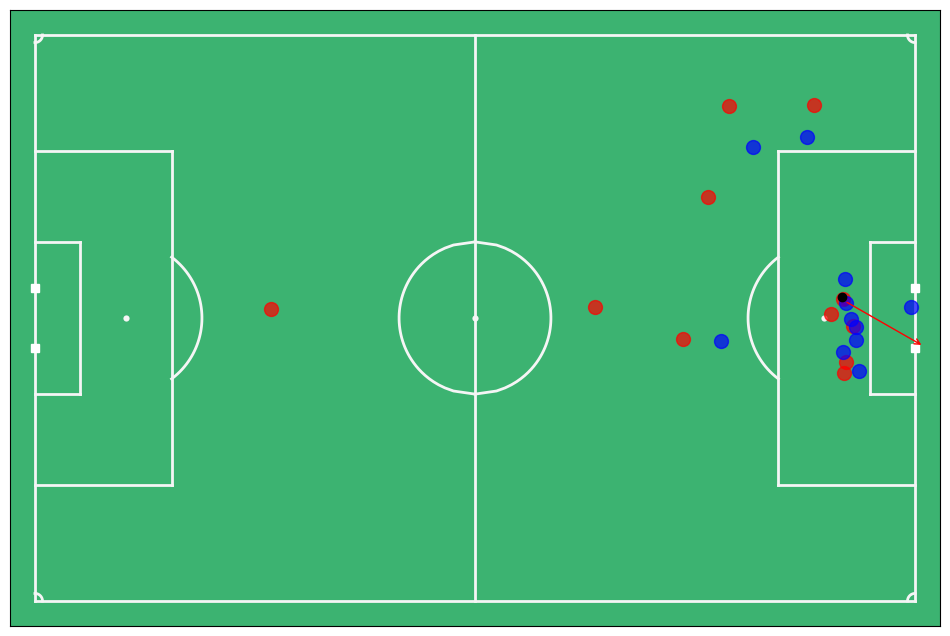

In [18]:
eventos = mio.read_event_data(DATADIR, game_id)

eventos = mio.to_metric_coordinates(eventos)

eventos_casa = eventos[eventos['Team'] == 'Home']
eventos_fora = eventos[eventos['Team'] == 'Away']

chutes = eventos[eventos['Type'] == 'SHOT']
chutes_casa = eventos_casa[eventos_casa.Type == 'SHOT']
chutes_fora = eventos_fora[eventos_fora.Type == 'SHOT']

gols_casa = chutes_casa[chutes_casa['Subtype'].str.contains('-GOAL')].copy()
gols_fora = chutes_fora[chutes_fora['Subtype'].str.contains('-GOAL')].copy()

gol = eventos.iloc[gols_casa.iloc[0].name]

fig,ax = mviz.plot_pitch()
ax.plot(gol['Start X'], gol['Start Y'], 'ro')
ax.annotate("", xy=gol[['End X','End Y']], xytext=gol[['Start X','Start Y']], alpha=0.6, arrowprops=dict(arrowstyle="->",color='r'))

gol_frame = eventos.iloc[gols_casa.iloc[0].name]['Start Frame']

tracking_casa = mio.tracking_data(DATADIR,game_id,'Home')
tracking_fora = mio.tracking_data(DATADIR,game_id,'Away')

tracking_casa = mio.to_metric_coordinates(tracking_casa)
tracking_fora = mio.to_metric_coordinates(tracking_fora)

fig,ax = mviz.plot_frame(tracking_casa.loc[gol_frame], tracking_fora.loc[gol_frame], figax=(fig,ax))

Agora faça um plot descrevendo a trajetória do jogador que finalizou considerando os 1500 frames anteriores ao gol/finalização

In [19]:
import re

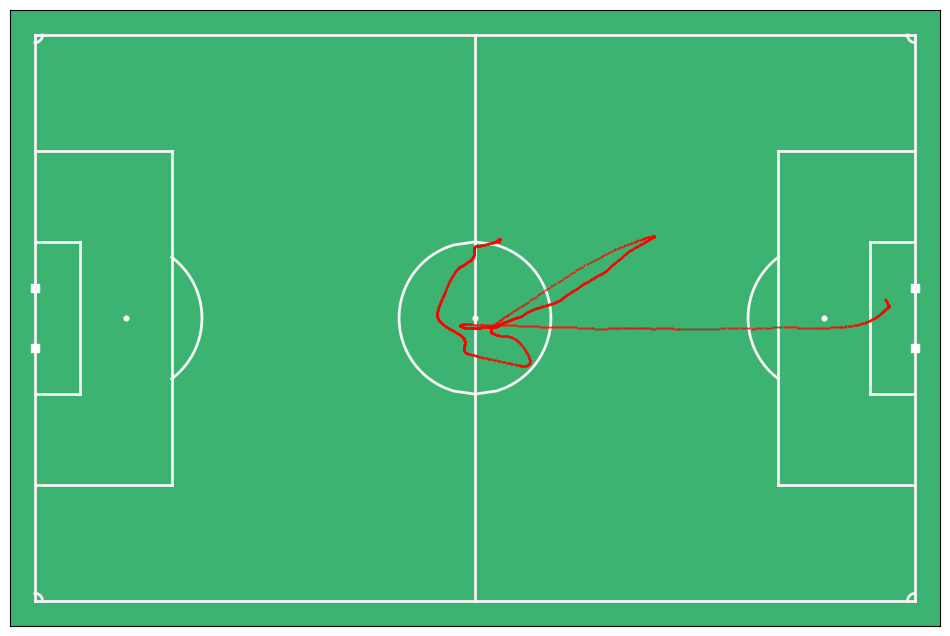

In [28]:
numJogador = number = re.search(r'\d+', gol['From']).group()

fig,ax = mviz.plot_pitch()
ax.plot(tracking_casa[f'Home_{numJogador}_x'].iloc[:1500], tracking_casa[f'Home_{numJogador}_y'].iloc[(gol_frame - 1500): gol_frame], 'r.', markersize=1)

## Parte 2

Utilize o código de "Tutorial2_DelvingDeeper.py" para calcular as velocidades dos jogadores em cada frame. Em seguida faça o plot de um frame qualquer incluindo vetores de velocidade.

(<Figure size 1200x800 with 1 Axes>, <Axes: >)

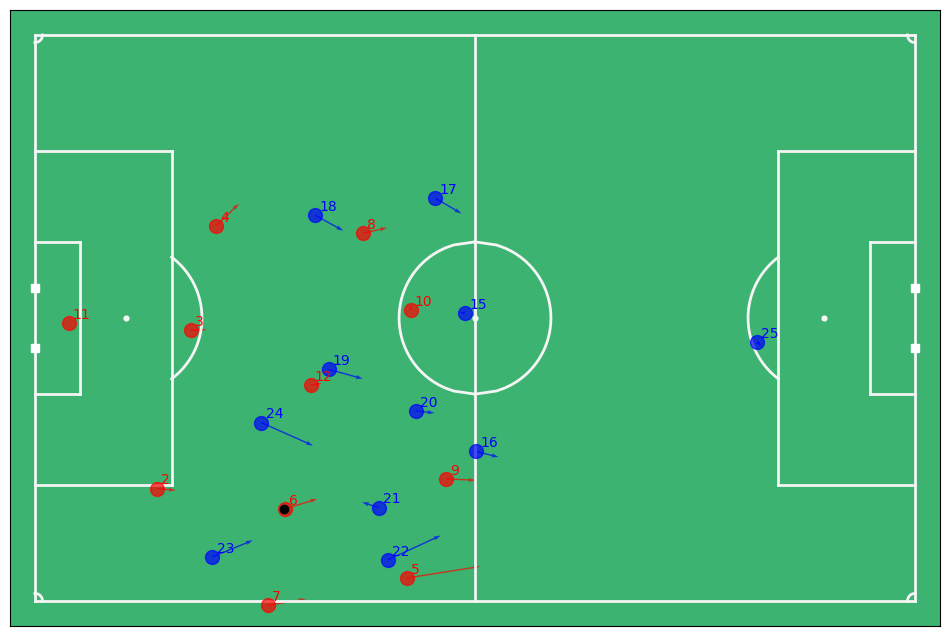

In [21]:
import Metrica_Velocity as mvel
import random

tracking_casa = mvel.calc_player_velocities(tracking_casa, smoothing=True)
tracking_fora = mvel.calc_player_velocities(tracking_fora, smoothing=True)

frame = random.randint(1, tracking_casa.shape[0])

mviz.plot_frame(tracking_casa.loc[frame],
                tracking_fora.loc[frame],
                include_player_velocities=True,
                annotate=True)

Crie um resumo físico para os jogadores envolvidos na partida. Plote as distâncias percorridas por cada jogador em cada ritmo (walking, jogging, running, sprinting)

Você consegue dizer a partir desse resumo quais jogadores são os goleiros?

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def resum_fisico(tracking, time_s):
    
    jogadores = np.unique( [ c.split('_')[1] for c in tracking.columns if c[:4] == time_s ] )
    time = pd.DataFrame(index=jogadores)

    minutos = []
    for jogador in time.index:
        column = time_s + '_' + jogador + '_x' 
        player_minutes = ( tracking[column].last_valid_index() - tracking[column].first_valid_index() + 1 ) / 25 / 60.
        minutos.append( player_minutes )
    time['minutos'] = minutos
    
    walking = []
    jogging = []
    running = []
    sprinting = []
    for jogador in time.index:
        coluna = time_s + '_' + jogador + '_speed'
        # < 2
        distancia_jogador = tracking.loc[tracking[coluna] < 2, coluna].sum()/25./1000
        walking.append(distancia_jogador)
        # 2 < x < 7
        distancia_jogador = tracking.loc[(tracking[coluna] >= 2) & (tracking[coluna] < 4), coluna].sum()/25./1000
        jogging.append(distancia_jogador)
        # 4 < x < 7
        distancia_jogador = tracking.loc[(tracking[coluna] >= 4) & (tracking[coluna] < 7), coluna].sum()/25./1000
        running.append(distancia_jogador)
        # > 7 m/s)
        distancia_jogador = tracking.loc[tracking[coluna] >= 7, coluna].sum()/25./1000
        sprinting.append(distancia_jogador)
        
    time['walking'] = walking
    time['jogging'] = jogging
    time['running'] = running
    time['sprinting'] = sprinting
    
    return time

casa = resum_fisico(tracking_casa, 'Home')
fora = resum_fisico(tracking_fora, 'Away')

fora.index = fora.index.astype(int) - casa.shape[0]

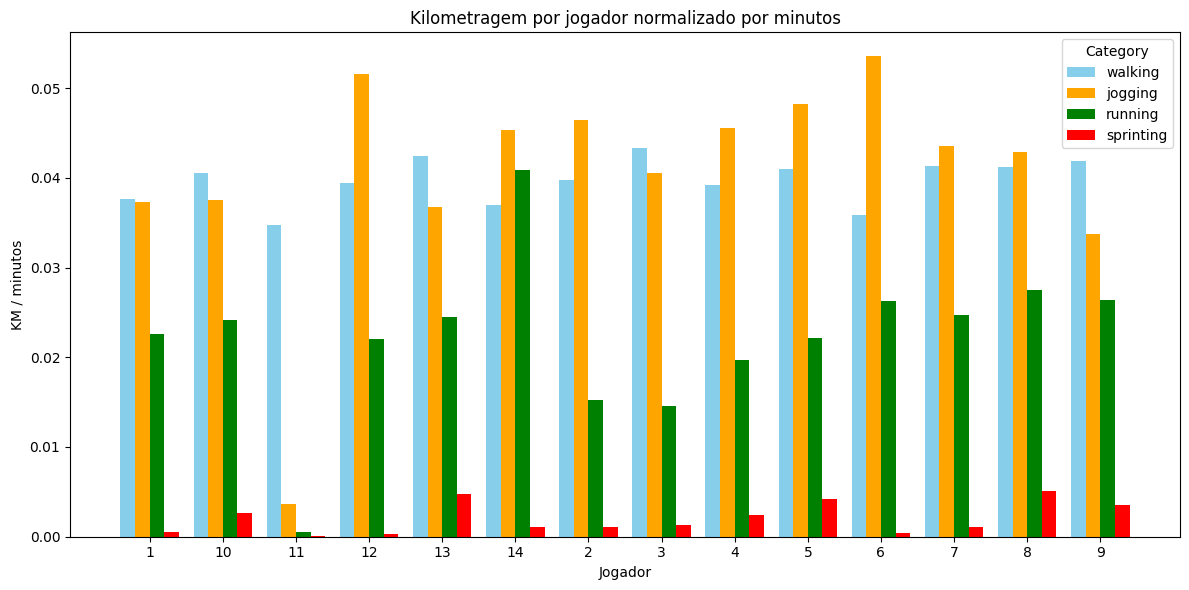

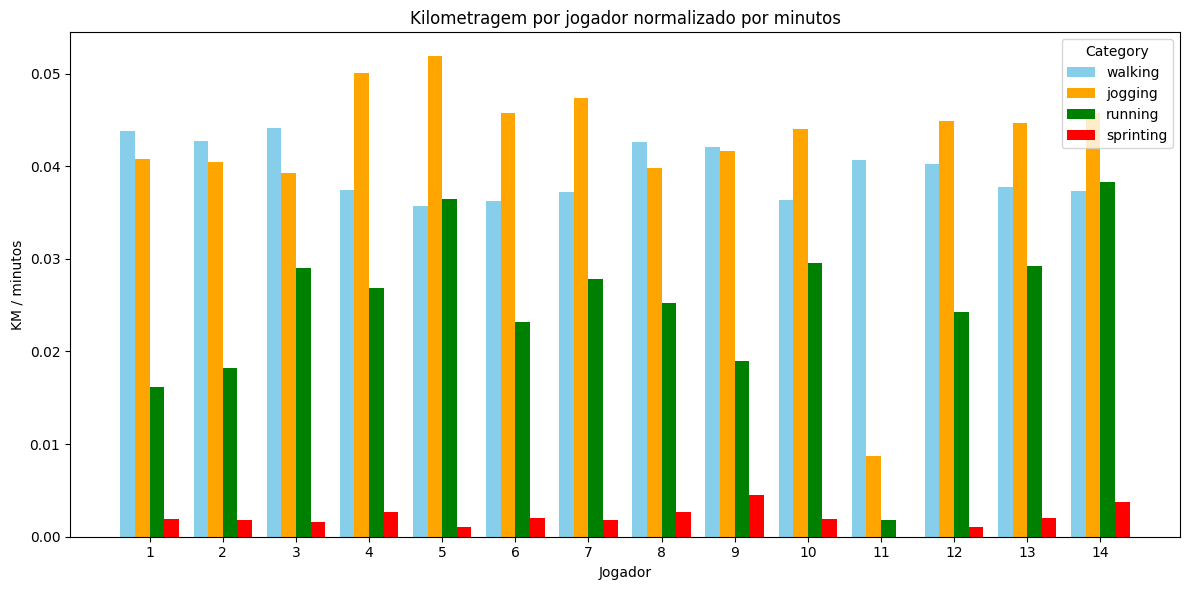

In [23]:
def plt_grafico(df):
    categorias = ['walking', 'jogging', 'running', 'sprinting']
    cores = {
        'walking': 'skyblue',
        'jogging': 'orange',
        'running': 'green',
        'sprinting': 'red'
    }

    df_normalizado = df.copy()
    for cat in categorias:
        df_normalizado[cat] = df_normalizado[cat] / df_normalizado['minutos']

    x = np.arange(len(df_normalizado))
    larg = 0.2
    padding = [-1.5, -0.5, 0.5, 1.5]

    fig, ax = plt.subplots(figsize=(12, 6))

    for cat, offset in zip(categorias, padding):
        ax.bar(x + offset * larg, df_normalizado[cat], width=larg, label=cat, color=cores[cat])

    ax.set_xlabel("Jogador")
    ax.set_ylabel("KM / minutos")
    ax.set_title("Kilometragem por jogador normalizado por minutos")
    ax.set_xticks(x)
    ax.set_xticklabels(df.index.astype(str))
    ax.legend(title="Category")
    plt.tight_layout()
    plt.show()

plt_grafico(casa)
plt_grafico(fora)

Provavelmente os jogadores 11(originalmente o 11 do time de fora é o 25) são os goleiros, pelo baixo valor de sprinting e running

Por fim, escolha um jogador e faça um plot com seus sprints no campo

In [24]:
tracking_casa,tracking_fora,eventos = mio.to_single_playing_direction(tracking_casa,tracking_fora,eventos)

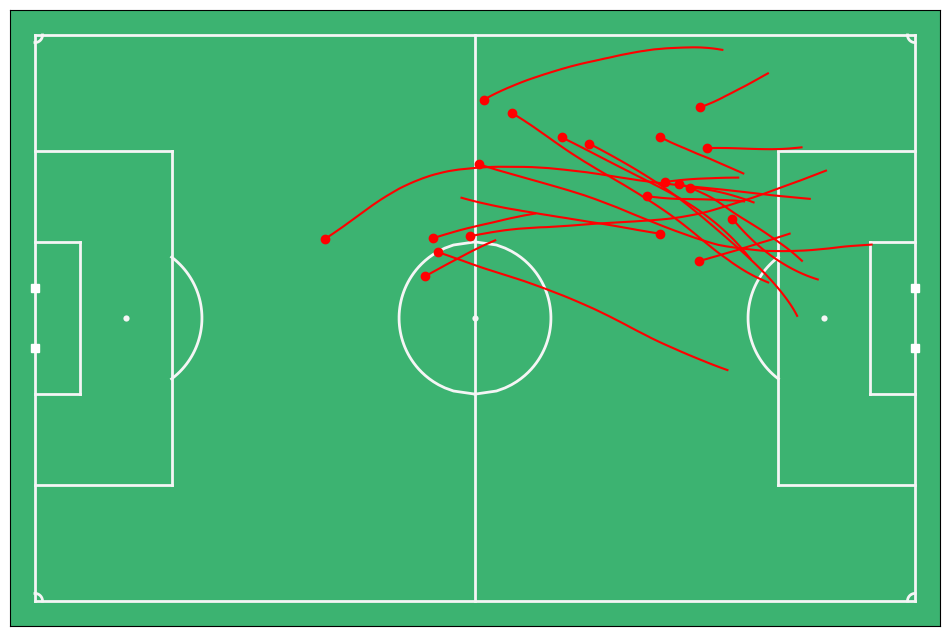

In [26]:
vel_sprint = 7
tam_sprint = 1 * 25  # 1 segundo a 25 Hz

while True:
    num = random.randint(1, casa.shape[0])
    column = 'Home_' + str(num) + '_speed'
    column_x = 'Home_' + str(num) + '_x'
    column_y = 'Home_' + str(num) + '_y'

    if column not in tracking_casa.columns:
        continue  # pula se o jogador não existe nos dados

    # Detectar sprints
    sprint_mask = 1 * (tracking_casa[column] >= vel_sprint)
    sprint_convolved = np.convolve(sprint_mask, np.ones(tam_sprint), mode='same')
    sprint_detected = np.diff(1 * (sprint_convolved >= tam_sprint))
    player_sprints_start = np.where(sprint_detected == 1)[0] - int(tam_sprint / 2) + 1
    player_sprints_end = np.where(sprint_detected == -1)[0] + int(tam_sprint / 2) + 1

    if len(player_sprints_start) > 0:
        break  # achou sprints válidas

fig,ax = mviz.plot_pitch()
for s,e in zip(player_sprints_start,player_sprints_end):
    ax.plot(tracking_casa[column_x].iloc[s],tracking_casa[column_y].iloc[s],'ro')
    ax.plot(tracking_casa[column_x].iloc[s:e+1],tracking_casa[column_y].iloc[s:e+1],'r')